#### EXPLORATORY DATA ANALYSIS OF VIDEOS IN A YOUTUBE CHANNEL AND SENTIMENT ANALYSIS OF THE COMMENTS.


First I'll import the necessary libraries.

In [150]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#from wordcloud import wordCloud

In [151]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#from wordcloud import WordCloud

Youtube API is Avaiable at https://developers.google.com/youtube/v3

In [152]:
api_key = 'AIzaSyBHTm###################6iaA'
#I used the hash tag for security and privacy reasons.

To get channel id for any page on youtube, follow these steps:
Open channel > right click and select view page source > press ctrl+F and search for channel_id

In [153]:
channel_ids = ['UC7cs8q-gJRlGwj4A8OmCmXg', 'UCiT9RITQ9PW6BhXK0y2jaeg' ]
#Channel IDs for Alex the analyst and Ken Jee on youtube.

In [323]:
#!pip install --upgrade google-api-python-client

  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.82.0
    Uninstalling google-api-python-client-2.82.0:
      Successfully uninstalled google-api-python-client-2.82.0


In [155]:
import json
api_service_name = "youtube"
api_version = "v3"
#client_secrets_file = "YOUR_CLIENT_SECRET_FILE.json"

# Get credentials and create an API client
youtube =build(
    api_service_name, api_version, developerKey = api_key)

request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids) #Concatenate all channel ids together if there's more than one
)
response = request.execute()
JSON(response)
print(json.dumps(response, indent=2, sort_keys=True))
# The code in this cell is gotten from youtube developer
#https://developers.google.com/youtube > references > chennels > list > try this API > python

{
  "etag": "eSo7aS6NdOVAmQpsDCGtO3B1nr8",
  "items": [
    {
      "contentDetails": {
        "relatedPlaylists": {
          "likes": "",
          "uploads": "UU7cs8q-gJRlGwj4A8OmCmXg"
        }
      },
      "etag": "bQwd4FIv6RzEKKYyXxRIz9dWo4g",
      "id": "UC7cs8q-gJRlGwj4A8OmCmXg",
      "kind": "youtube#channel",
      "snippet": {
        "country": "US",
        "customUrl": "@alextheanalyst",
        "description": "My name is Alex Freberg and on this channel I will be going over everything you need to know to become a Data Analyst. If you are wanting to make a career change or learn the skills needed to become a Data Analyst, be sure to subscribe to stay up to date on all my latest content.\n\nYou can find me on LinkedIn at:\nhttps://www.linkedin.com/in/alex-freberg/\n\nAlexTheAnalyst.com\nhttps://www.alextheanalyst.com/\n\nDiscord Channel:\nhttps://discord.gg/rxZUjNvRzR\n\nTwitter:\n@Alex_TheAnalyst\n\nSend Me Something:\n431 Saint James Avenue Suite L #318, Goose Creek

In [6]:
pd.DataFrame.from_dict(response, orient='index')

,0
kind,youtube#channelListResponse
etag,4VQKApBbaS3oA4ZM8lxXnD4iZC8
pageInfo,"{'totalResults': 2, 'resultsPerPage': 5}"
items,"[{'kind': 'youtube#channel', 'etag': '3qoPQF3l..."


In [7]:
#Function to get the data we need by iterating through nested dictionaries and creating headers for them.

def channel_info(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids)
    )
    response = request.execute()
    #we'll loop through the items since all the info we need are under items.
    #some are under sublevels under items.
    for i in range(len(response['items'])):
        data = {'channelName': response['items'][i]['snippet']['title'],
               'subscribers':  response['items'][i]['statistics']['subscriberCount'],
                'views':  response['items'][i]['statistics']['viewCount'],
                'totalViews':  response['items'][i]['statistics']['videoCount'],
                'playlistId': response['items'][i]['contentDetails']['relatedPlaylists']['uploads']        
               }
        all_data.append(data)
    return(pd.DataFrame(all_data))


In [8]:
channel_data = channel_info(youtube, channel_ids)

In [9]:
channel_data

,channelName,subscribers,views,totalViews,playlistId
0,Ken Jee,240000,7893387,273,UUiT9RITQ9PW6BhXK0y2jaeg
1,Alex The Analyst,436000,17039615,201,UU7cs8q-gJRlGwj4A8OmCmXg


In [10]:
request = youtube.playlistItems().list(
    part="snippet, contentDetails",
    playlistId='UU7cs8q-gJRlGwj4A8OmCmXg'
)
response = request.execute()
JSON(response)
print(json.dumps(response, indent=2, sort_keys=True))

#Also gotten from youtube developer but this time from playlistitems under references.


{
  "etag": "HnBz9YWeKpd9K9zAasLwSGj-FSE",
  "items": [
    {
      "contentDetails": {
        "videoId": "VRmXto2YA2I",
        "videoPublishedAt": "2023-04-04T11:30:10Z"
      },
      "etag": "CaP2AFOqzT48C_M096XMwKflQ3s",
      "id": "VVU3Y3M4cS1nSlJsR3dqNEE4T21DbVhnLlZSbVh0bzJZQTJJ",
      "kind": "youtube#playlistItem",
      "snippet": {
        "channelId": "UC7cs8q-gJRlGwj4A8OmCmXg",
        "channelTitle": "Alex The Analyst",
        "description": "In this series we will be walking through everything you need to know to get started in Pandas! In this video, we learn about Group By and Aggregate Functions in Pandas.\n\nDataset in GitHub: https://github.com/AlexTheAnalyst/PandasYouTubeSeries/blob/main/Flavors.csv\n\nCode in GitHub: https://github.com/AlexTheAnalyst/PandasYouTubeSeries/blob/main/Pandas%20101%20-%20Group%20by%20and%20Aggregating%20in%20Pandas.ipynb\n\nFavorite Pandas Course:\nData Analysis with Pandas and Python - https://bit.ly/3KHMLlu\n_______________________

In [11]:
playlist_id = 'UU7cs8q-gJRlGwj4A8OmCmXg'

def video_ids_info(youtube, playlist_id):
    video_ids = []
    request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        playlistId=playlist_id,
        maxResults = 50 #The video ids gotten is 5 by default, hence, the reason for this argument.
   )
    
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken') #This is useful when there are more than 50 videos on the channel.
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token
           )
        response = request.execute()
    
    
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    
    
    return video_ids

In [12]:
video_ids = video_ids_info(youtube, playlist_id)

In [13]:
video_ids

['VRmXto2YA2I',
 '6yNsc7JVPJE',
 'mBCG9J1TVTc',
 'WizLaDdsHUs',
 'kB7FV-ijdqE',
 'dFA0E-6xT_M',
 'dUpyC40cF6Q',
 'gs0FNQR0njI',
 'C75TROiiEa0',
 'rGx1QNdYzvs',
 'CUBfrdDwznQ',
 'L-QnW_BZT3c',
 'S76iS03nGis',
 'RBEgsEVO3T8',
 'gCG07l6Fu-U',
 'DXwFsxCtukg',
 'ey1VNjU0YbM',
 '0MKcCHrTo0c',
 'bVJfQAe-UP4',
 '_2OknmkngkQ',
 'B63bN2cLVLM',
 'zvzjaqMBEso',
 'ECduJk00mUU',
 'zmIdC0_0BgY',
 'eP8-mo5jRrY',
 '-BOBedcjySI',
 'lPVke-p4S7s',
 'ppsCxnNm-JI',
 'rVhHGPDzEck',
 'pHOH7UfOhbE',
 'sXHIIW3Wt84',
 'WUeBzT43JyY',
 'DVs9u15htXU',
 'zW3qJUeJLWc',
 'm1AkWK_ODLM',
 'Pfq-8pGzgg4',
 'pixlHHe_lNQ',
 '3NV5Jtbhfcw',
 '1cfrQLoJMPI',
 '9j_EBt3RNrs',
 'm0h3Ghl6mgY',
 '50D__p6jdEI',
 'tRCGGlMI19M',
 '0QZBnhofU_U',
 'ulFY20KTzFQ',
 'PEc29sRZoTM',
 'DlEkWd-8VXA',
 'vcijg0gUXSg',
 'gCg47n_TlFc',
 'sW5LoDA1ssM',
 '4nsdARJGzJ0',
 '_QvQxm4dptI',
 'HX2TabgkzHo',
 'gP-AxNi6uxo',
 'KB2CtEDrglY',
 '2HfSFdPEFRg',
 'g0m5sEHPU-s',
 'Q7i6zxHVj2Q',
 'ddn-2r1j_OU',
 'Pf-9pjJK1e0',
 '-bSkREem8dM',
 'xKdtP3IZbnU',
 'GsAXOr

In [15]:
len(video_ids)
#This implies there are 201 videos on this channel as at the time I ran the script.

201

In [14]:
request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=video_ids[:5]
    )
response = request.execute()

print(response)

{'kind': 'youtube#videoListResponse', 'etag': 'qDqS4U7Q9-jj3EskAeUKwT7DWt8', 'items': [{'kind': 'youtube#video', 'etag': 'eDu9ImW4ciBr7vQcorW2KhY5JVQ', 'id': 'VRmXto2YA2I', 'snippet': {'publishedAt': '2023-04-04T11:30:10Z', 'channelId': 'UC7cs8q-gJRlGwj4A8OmCmXg', 'title': 'Group By and Aggregate Functions in Pandas | Python Pandas Tutorials', 'description': "In this series we will be walking through everything you need to know to get started in Pandas! In this video, we learn about Group By and Aggregate Functions in Pandas.\n\nDataset in GitHub: https://github.com/AlexTheAnalyst/PandasYouTubeSeries/blob/main/Flavors.csv\n\nCode in GitHub: https://github.com/AlexTheAnalyst/PandasYouTubeSeries/blob/main/Pandas%20101%20-%20Group%20by%20and%20Aggregating%20in%20Pandas.ipynb\n\nFavorite Pandas Course:\nData Analysis with Pandas and Python - https://bit.ly/3KHMLlu\n____________________________________________ \n\nSUBSCRIBE!\nDo you want to become a Data Analyst? That's what this channel is

In [16]:
def get_video_info(youtube, video_ids):
    video_data = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=','.join(video_ids[i:i+50]))
        response = request.execute()
        
        for video in response['items']:
            stats_header= {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
            }
            video_info = {}
            video_info['video_id']= video['id']
            for x in stats_header.keys():
                for y in stats_header[x]:
                    try:
                        video_info[y] = video[x][y]
                    except:
                        video_info[y] = None
                    
                    
            video_data.append(video_info)
            
    return pd.DataFrame(video_data)
                   


In [17]:
video_df = get_video_info(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,VRmXto2YA2I,Alex The Analyst,Group By and Aggregate Functions in Pandas | P...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-04-04T11:30:10Z,4304,125,None,14,PT11M5S,hd,false
1,6yNsc7JVPJE,Alex The Analyst,Top 5 Biggest Mistakes Beginner Data Analysts ...,Everybody makes mistakes. Everybody has those ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-28T11:30:04Z,21615,1135,None,71,PT8M54S,hd,false
2,mBCG9J1TVTc,Alex The Analyst,Indexes in Pandas | Python Pandas Tutorials,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-21T11:30:30Z,5903,149,None,15,PT11M22S,hd,false
3,WizLaDdsHUs,Alex The Analyst,Create the Perfect Data Analyst Resume | Free ...,Building a great Resume is crucial to landing ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-14T11:30:10Z,33822,1413,None,115,PT17M37S,hd,false
4,kB7FV-ijdqE,Alex The Analyst,Filtering Columns and Rows in Pandas | Python ...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-07T12:30:30Z,9478,236,None,26,PT11M49S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,4rfr6A3lO-Y,Alex The Analyst,Data Analyst Resume | Reviewing My Resume! | F...,Data Analyst Resume | Reviewing My Resume! | F...,"[Data Analyst, How to become a data analyst, D...",2020-01-30T14:07:55Z,60768,1487,None,64,PT7M33S,hd,false
197,OTq2NRy_AGs,Alex The Analyst,Working at a Big Company Vs Small Company | To...,Working at a Big Company Vs Small Company | To...,"[Data Analyst, How to become a Data Analyst, B...",2020-01-25T16:38:39Z,13375,368,None,21,PT5M50S,hd,false
198,ya28cb3zFGE,Alex The Analyst,Data Analyst Salary | 100k with No Experience,Data Analyst Salary | 100k with No Experience ...,"[Data Analyst Salary, Data analyst with no exp...",2020-01-23T03:16:09Z,57278,2019,None,224,PT5M3S,hd,false
199,Hsi2BG0SOiQ,Alex The Analyst,Truth About Big Companies | Told by a Fortune ...,Truth About Big Companies // There are a ton o...,"[Working at a big company, Big company data an...",2020-01-21T03:52:15Z,7142,272,None,17,PT5M45S,hd,false


In [18]:
def video_comments(youtube, vids):
    
    all_comments = []
    
    for vid in vids:
        try:
            request = youtube.commentThreads().list(
            part='snippet, replies',
            videoId=vid
            )
            response = request.execute()

            vid_comments = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_info = {'vid': vid, 'comments': vid_comments}

            all_comments.append(comments_info)
        
        except:
            #In case the comments are turned off
            print('Comments are not allowed on ' + vid)
        
        
    return pd.DataFrame(all_comments)

In [19]:
pd.set_option('display.max_columns', None)
comment_df = video_comments(youtube, video_ids)
comment_df[:10]

,vid,comments
0,VRmXto2YA2I,[is data analyst oversaturated? someone said t...
1,6yNsc7JVPJE,[Well…. time to go into work tomorrow and docu...
2,mBCG9J1TVTc,[Hi Alex - it would be amazing if you did a de...
3,WizLaDdsHUs,"[You are an amazing person, you know that?, Ia..."
4,kB7FV-ijdqE,[the best pandas filtering tut i have watched....
5,dFA0E-6xT_M,[Hi Alex! thank you for your videos. I just di...
6,dUpyC40cF6Q,[Thank you for being a truely outstanding teac...
7,gs0FNQR0njI,"[The PCWizKid mouse cursor is a classic., I di..."
8,C75TROiiEa0,"[As a new R programmer, I turned to chat gpt 4..."
9,rGx1QNdYzvs,"[Alex thank you for the content, Im not sure i..."


In [20]:
video_df.isna().sum()
#Checking for null values

video_id            0
channelTitle        0
title               0
description         0
tags                1
publishedAt         0
viewCount           0
likeCount           0
favouriteCount    201
commentCount        0
duration            0
definition          0
caption             0
dtype: int64

In [21]:
#Changing the data type of the column 'publishedAt' to string
video_df['publishedAt'] = video_df['publishedAt'].astype(str)

In [22]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [23]:
# Converting the columns below to numeric type.
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [24]:
#Publish day in the week
from dateutil import parser
#The current time format is part of the ISO 8601 collection of standard date-time text formats and I have to convert to my timezone(UTC+1)
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
#Introducing day of the week column
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [25]:
#Convert duration to seconds

import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [26]:
video_df['durationSecs']

0       665.0
1       534.0
2       682.0
3      1057.0
4       709.0
        ...  
196     453.0
197     350.0
198     303.0
199     345.0
200     160.0
Name: durationSecs, Length: 201, dtype: float64

In [27]:
video_df['publishedDayName']

0       Tuesday
1       Tuesday
2       Tuesday
3       Tuesday
4       Tuesday
         ...   
196    Thursday
197    Saturday
198    Thursday
199     Tuesday
200      Friday
Name: publishedDayName, Length: 201, dtype: object

In [28]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs
0,VRmXto2YA2I,Alex The Analyst,Group By and Aggregate Functions in Pandas | P...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-04-04 11:30:10+00:00,4304.0,125.0,NaN,14.0,PT11M5S,hd,false,Tuesday,665.0
1,6yNsc7JVPJE,Alex The Analyst,Top 5 Biggest Mistakes Beginner Data Analysts ...,Everybody makes mistakes. Everybody has those ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-28 11:30:04+00:00,21615.0,1135.0,NaN,71.0,PT8M54S,hd,false,Tuesday,534.0
2,mBCG9J1TVTc,Alex The Analyst,Indexes in Pandas | Python Pandas Tutorials,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-21 11:30:30+00:00,5903.0,149.0,NaN,15.0,PT11M22S,hd,false,Tuesday,682.0
3,WizLaDdsHUs,Alex The Analyst,Create the Perfect Data Analyst Resume | Free ...,Building a great Resume is crucial to landing ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-14 11:30:10+00:00,33822.0,1413.0,NaN,115.0,PT17M37S,hd,false,Tuesday,1057.0
4,kB7FV-ijdqE,Alex The Analyst,Filtering Columns and Rows in Pandas | Python ...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-07 12:30:30+00:00,9478.0,236.0,NaN,26.0,PT11M49S,hd,false,Tuesday,709.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,4rfr6A3lO-Y,Alex The Analyst,Data Analyst Resume | Reviewing My Resume! | F...,Data Analyst Resume | Reviewing My Resume! | F...,"[Data Analyst, How to become a data analyst, D...",2020-01-30 14:07:55+00:00,60768.0,1487.0,NaN,64.0,PT7M33S,hd,false,Thursday,453.0
197,OTq2NRy_AGs,Alex The Analyst,Working at a Big Company Vs Small Company | To...,Working at a Big Company Vs Small Company | To...,"[Data Analyst, How to become a Data Analyst, B...",2020-01-25 16:38:39+00:00,13375.0,368.0,NaN,21.0,PT5M50S,hd,false,Saturday,350.0
198,ya28cb3zFGE,Alex The Analyst,Data Analyst Salary | 100k with No Experience,Data Analyst Salary | 100k with No Experience ...,"[Data Analyst Salary, Data analyst with no exp...",2020-01-23 03:16:09+00:00,57278.0,2019.0,NaN,224.0,PT5M3S,hd,false,Thursday,303.0
199,Hsi2BG0SOiQ,Alex The Analyst,Truth About Big Companies | Told by a Fortune ...,Truth About Big Companies // There are a ton o...,"[Working at a big company, Big company data an...",2020-01-21 03:52:15+00:00,7142.0,272.0,NaN,17.0,PT5M45S,hd,false,Tuesday,345.0


In [29]:
#Inquiry to confirm if there are captions with  'True' as the value
video_df[video_df['caption']== 'true']

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs
54,KB2CtEDrglY,Alex The Analyst,Automating Crypto Website API Pull Using Pytho...,In this project we look at automating this API...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-06-07 10:30:10+00:00,23329.0,510.0,NaN,68.0,PT51M14S,hd,true,Tuesday,3074.0
71,3irO29PJQHs,Alex The Analyst,Best Coursera Courses for Data Analysts in 2022,"I've taken a lot of courses, maybe too many, b...","[Data Analyst, Data Analyst job, Data Analyst ...",2022-02-08 11:30:01+00:00,86158.0,4754.0,NaN,196.0,PT9M32S,hd,true,Tuesday,572.0


In [30]:
#Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [77]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs,tagCount
0,VRmXto2YA2I,Alex The Analyst,Group By and Aggregate Functions in Pandas | P...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-04-04 11:30:10+00:00,4304.0,125.0,NaN,14.0,PT11M5S,hd,false,Tuesday,665.0,16
1,6yNsc7JVPJE,Alex The Analyst,Top 5 Biggest Mistakes Beginner Data Analysts ...,Everybody makes mistakes. Everybody has those ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-28 11:30:04+00:00,21615.0,1135.0,NaN,71.0,PT8M54S,hd,false,Tuesday,534.0,5
2,mBCG9J1TVTc,Alex The Analyst,Indexes in Pandas | Python Pandas Tutorials,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-21 11:30:30+00:00,5903.0,149.0,NaN,15.0,PT11M22S,hd,false,Tuesday,682.0,14
3,WizLaDdsHUs,Alex The Analyst,Create the Perfect Data Analyst Resume | Free ...,Building a great Resume is crucial to landing ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-14 11:30:10+00:00,33822.0,1413.0,NaN,115.0,PT17M37S,hd,false,Tuesday,1057.0,13
4,kB7FV-ijdqE,Alex The Analyst,Filtering Columns and Rows in Pandas | Python ...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2023-03-07 12:30:30+00:00,9478.0,236.0,NaN,26.0,PT11M49S,hd,false,Tuesday,709.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,4rfr6A3lO-Y,Alex The Analyst,Data Analyst Resume | Reviewing My Resume! | F...,Data Analyst Resume | Reviewing My Resume! | F...,"[Data Analyst, How to become a data analyst, D...",2020-01-30 14:07:55+00:00,60768.0,1487.0,NaN,64.0,PT7M33S,hd,false,Thursday,453.0,15
197,OTq2NRy_AGs,Alex The Analyst,Working at a Big Company Vs Small Company | To...,Working at a Big Company Vs Small Company | To...,"[Data Analyst, How to become a Data Analyst, B...",2020-01-25 16:38:39+00:00,13375.0,368.0,NaN,21.0,PT5M50S,hd,false,Saturday,350.0,17
198,ya28cb3zFGE,Alex The Analyst,Data Analyst Salary | 100k with No Experience,Data Analyst Salary | 100k with No Experience ...,"[Data Analyst Salary, Data analyst with no exp...",2020-01-23 03:16:09+00:00,57278.0,2019.0,NaN,224.0,PT5M3S,hd,false,Thursday,303.0,14
199,Hsi2BG0SOiQ,Alex The Analyst,Truth About Big Companies | Told by a Fortune ...,Truth About Big Companies // There are a ton o...,"[Working at a big company, Big company data an...",2020-01-21 03:52:15+00:00,7142.0,272.0,NaN,17.0,PT5M45S,hd,false,Tuesday,345.0,7


### Which video has the most views?

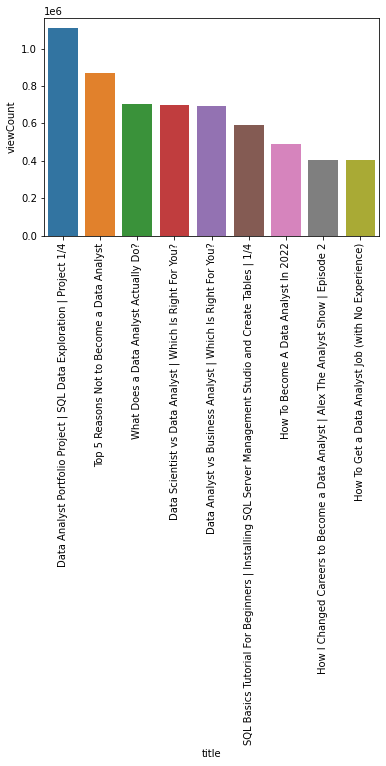

In [32]:
ax = sn.barplot(x='title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot =   ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.000f}'.format(x/1000000) + 'M' ))

#### View distribution per video

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

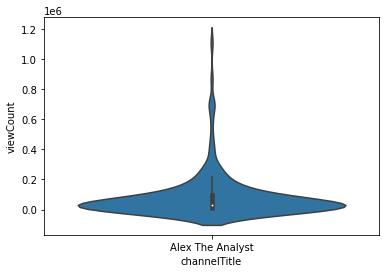

In [33]:
sn.violinplot(video_df['channelTitle'], video_df['viewCount'])

#### Correlation between views and comment VS like and comment

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

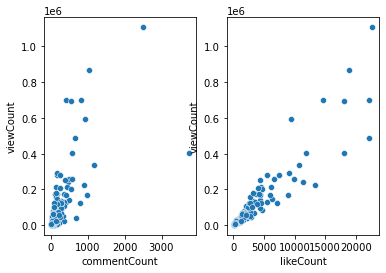

In [33]:
fig, ax = plt.subplots(1,2)
sn.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sn.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

#### Video count based on duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

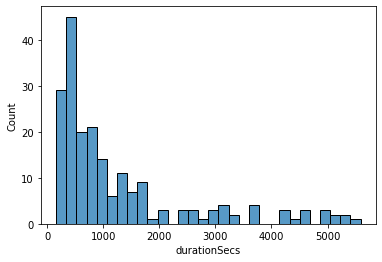

In [34]:
sn.histplot(data =  video_df, x = 'durationSecs', bins = 30)

####  Which day does he upload videos the most?

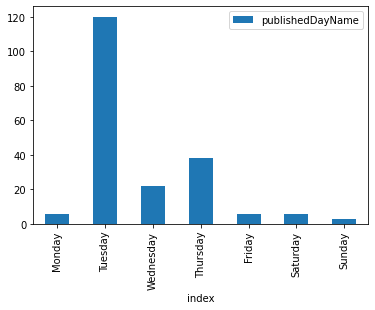

In [147]:
day_df = pd.DataFrame(video_df['publishedDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishedDayName', rot = 90)

#### NATURAL LANGUAGE PROCESSING

In [156]:
all_comment = []
    
for vi in video_ids:
    try:
        request = youtube.commentThreads().list(
        part='snippet, replies',
        videoId=vi
        )
        response = request.execute()

        vid_comment = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:50]]
        comments_infos = {'vid': vi, 'comments': vid_comment}

        all_comment.append(comments_infos)

    except:
        #In cases where the comments are turned off
        print('Comments are not allowed on ' + vi)
        
        
all_df = pd.DataFrame(all_comment)
all_df.head()

,vid,comments
0,VRmXto2YA2I,[is data analyst oversaturated? someone said t...
1,6yNsc7JVPJE,[Well…. time to go into work tomorrow and docu...
2,mBCG9J1TVTc,[Hi Alex - it would be amazing if you did a de...
3,WizLaDdsHUs,[What are your thoughts on how to handle the e...
4,kB7FV-ijdqE,[the best pandas filtering tut i have watched....


In [157]:
#pd.options.display.max_colwidth = 50
j_dict = pd.DataFrame(all_comment)
grp = j_dict.explode('comments') #This line enables us to have each comment as a row
grp

,vid,comments
0,VRmXto2YA2I,is data analyst oversaturated? someone said th...
0,VRmXto2YA2I,"What did Boris do, to be the pandas course of ..."
0,VRmXto2YA2I,3:27 note that to avoid a FutureWarning (and a...
0,VRmXto2YA2I,“Squiggly bracket” > “curly bracket” 😂\n\nAlso...
0,VRmXto2YA2I,Thanks Sir
...,...,...
200,6lQzbk6_OTw,Knime?
200,6lQzbk6_OTw,"Hi Alex, Awesome content, should I learn machi..."
200,6lQzbk6_OTw,Alex thanks for being the voice young analysts...
200,6lQzbk6_OTw,Than alex


In [158]:
import pprint
pprint.pprint(all_comment)
#This prints all the comments on a new line.

[{'comments': ['is data analyst oversaturated? someone said that, wdyt alex?',
               'What did Boris do, to be the pandas course of choice on Udemy '
               'to receive paid promotion?',
               '3:27 note that to avoid a FutureWarning (and an error later), '
               "you need to specify df.groupby('Base "
               "Flavor').mean(numeric_only = True)",
               '“Squiggly bracket” > “curly bracket” 😂\n'
               '\n'
               'Also the first time I’ve seen describe() with groupby(). Makes '
               'total sense, thank you!',
               'Thanks Sir',
               'I really like this series and many thanks to Alex for sharing '
               'such useful knowledge.',
               'This was very helpful, thank you!',
               'I am interested  to become  a data analyst  where do i begin, '
               'dont you have a beginner  course? Or community  so that we can '
               'join?  I dont have any infor

               'They cancelled my Spotify internship for software engineering '
               ':C\n'
               '\n'
               "But I'll keep at it!",
               'In india they blame PM Modi for inflation',
               'Are you Italian descent anyway? You sound much like Rafael Di '
               'Furia from Globe Trotter channel.',
               'Working remote saves so much money in so many different ways '
               'like gas, food, clothes/work clothes. It also saves your '
               'mental state by being able to work comfortably in your own '
               'home so you can watch your kids and take care of other family '
               'needs',
               "Maybe I don't quite understand, but if a whole bunch of people "
               'are resigning then why would there be a problem with the '
               'hiring freeze and layoffs?',
               'The last several minutes of the video was amazing. I hope to '
               'get to that poin

               'and have been in IT for almost 20 years. I want to change '
               "careers (I know it's never too late), and the data analyst "
               'part (as a researcher and report creation) really appeals to '
               'me. I am applying the knowledge I am picking up with the '
               'channels and with this order, I see more sense to the '
               'training. Many thanks to Alex and the community!',
               'Thank you for this video! This is very Thorough. I love how '
               'you explained each step. Very clearly explained and it was '
               'easy to follow.',
               'I wanna get involved if anyone had any tips for a total '
               'beginner other than following said videos let me know I look '
               'forward to my journey 😊',
               'Alex, I want to become a Data analyst. And please I want you '
               'to put me through it all. I am total beginner.',
               "Hello Sir,

               'viewers coming back. Fix it.',
               'I would like to know how I  could get my first job as a data '
               'analyst. Thanks a lot!',
               'Are there any Data Analysts professional associations out '
               'there that you would recommend?',
               'dear my teacher Alex, thank you for all, I am watching your '
               'channel through auto subtitle.although I live middle east I '
               'learn data Thanks to you my Teacher'],
  'vid': 'qewHAdfzLOw'},
 {'comments': ['Few days i’ve been considering about buying a laptop and doing '
               'some research on the marketplace.\n'
               '\n'
               'My option 1 - Lenovo ideapad slim 5 (Amd Ryzen 7, 16gb ram, '
               '512ssd)\n'
               '\n'
               'Option 2 - MSI Modern 14 (Intel Core i5, 16ram, 512ssd) or MSI '
               'Thin (Intel Core i5, 16ram, 1tb ssd)\n'
               '\n'
               'Option 3 - Asus Viv

               'realizes this after 40 minutes of watching the video 😉',
               '<3',
               'Asparagus. Very interesting',
               'Asparagus!! Great interview and advise. Thanks!!',
               'Asparagus!',
               'Asparagus :D  Thanks for another loaded and rich interview!!',
               'Asparagus',
               'Great learning experience - asparagus',
               'Awesome video Alex, this was just the thing I was looking for. '
               'I am very keen about Analytics Consulting and this video '
               'provides such good value to people like us who want to break '
               'into this field.\n'
               'Also, wonderful thing you are doing with this channel, great '
               'content. \n'
               'Thankyou.',
               'Asparagus!\n'
               '\n'
               'Im surprised he is 31 years old!, IU feel old and way behind '
               'on my carrer now 😓😓😓😓... how old are you alex??\n

               "I just have a question, can't we do HAVING count(JobTitle)  "
               'even though we group by salary, isnt that possible? thank you',
               'Yo! What did Michael do to Toby in this video?',
               'Helpful and really good explanation',
               'Can someone explain to me why \n'
               '\n'
               'SELECT JobTitle, AVG(Salary) AS avgsalary\r\n'
               '\r\n'
               'FROM EmployeeDemographics\r\n'
               'JOIN EmployeeSalary\r\n'
               'ON EmployeeDemographics.EmployeeID = '
               'EmployeeSalary.EmployeeID\r\n'
               'GROUP BY JobTitle\r\n'
               'HAVING avgsalary > 45000\r\n'
               'ORDER BY avgsalary\n'
               '\n'
               '\n'
               'is not working and I have to change the HAVING avgsalary > '
               '45000 to  HAVING AVG(Salary) > 45000?\n'
               'I just wanted to try other methods if I could use HAVING '
      

In [41]:
import spacy
nlp = spacy.load('en_core_web_sm')

#### DATA PREPROCESSING
First, I'll remove stop words and punctuations

In [42]:
import spacy
def preprocess(text):
    doc = nlp(text)
    no_stop_words = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(no_stop_words)

In [159]:
grp['processed_comment'] = grp['comments'].apply(preprocess)
grp

,vid,comments,processed_comment
0,VRmXto2YA2I,is data analyst oversaturated? someone said th...,data analyst oversaturated said wdyt alex
0,VRmXto2YA2I,"What did Boris do, to be the pandas course of ...",Boris pandas course choice Udemy receive paid ...
0,VRmXto2YA2I,3:27 note that to avoid a FutureWarning (and a...,3:27 note avoid FutureWarning error later need...
0,VRmXto2YA2I,“Squiggly bracket” > “curly bracket” 😂\n\nAlso...,Squiggly bracket > curly bracket 😂 \n\n time s...
0,VRmXto2YA2I,Thanks Sir,Thanks Sir
...,...,...,...
200,6lQzbk6_OTw,Knime?,Knime
200,6lQzbk6_OTw,"Hi Alex, Awesome content, should I learn machi...",Hi Alex Awesome content learn machine learning...
200,6lQzbk6_OTw,Alex thanks for being the voice young analysts...,Alex thanks voice young analysts need 👏 🏾
200,6lQzbk6_OTw,Than alex,alex


#### VADER sentiment scoring:
VADER means Valence Aware Dictionary for Sentiment Reasoning. It computes the individual sentiment of a statement and gives an overall score for the sentiment. It uses Bag of Words approach. Negative score means negative sentiment, zero means neutral while positive score implies positive sentiment. The scores are usually between -1 and +1.

In [44]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [45]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [299]:
sia.polarity_scores('He is so full of joy')
#checking the sentiment of random statements

{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'compound': 0.6204}

In [47]:
sia.polarity_scores('This is so messed up')
#checking the sentiment of random statements

{'neg': 0.438, 'neu': 0.562, 'pos': 0.0, 'compound': -0.4795}

Second, I'll run sentiment analysis on the  aggregated  comments on each video, i.e taking all the comments into consideration before scoring them.

In [161]:
res = {}
for i, row in grp.iterrows():
    text = row['processed_comment']
    vid_id = row['vid']
    res[vid_id] = sia.polarity_scores(text)
#Running the sentiment on the comments on each video

In [162]:
res

{'VRmXto2YA2I': {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0},
 '6yNsc7JVPJE': {'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compound': 0.8555},
 'mBCG9J1TVTc': {'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'compound': 0.3612},
 'WizLaDdsHUs': {'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.8807},
 'kB7FV-ijdqE': {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249},
 'dFA0E-6xT_M': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 'dUpyC40cF6Q': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 'gs0FNQR0njI': {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404},
 'C75TROiiEa0': {'neg': 0.172,
  'neu': 0.728,
  'pos': 0.099,
  'compound': -0.2732},
 'rGx1QNdYzvs': {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.3612},
 'CUBfrdDwznQ': {'neg': 0.0, 'neu': 0.56, 'pos': 0.44, 'compound': 0.9265},
 'L-QnW_BZT3c': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 'S76iS03nGis': {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404},
 'RBEgsEVO3T8':

In [163]:
vaders = pd.DataFrame(res).T
vaders.reset_index(inplace = True)
vaders.rename(columns = {'index' : 'video_id'}, inplace = True)
vaders = vaders.merge(video_df, on = 'video_id', how = 'inner' )
vaders

In [171]:
vade = vaders[['video_id','compound','title', 'likeCount' ]]

In [172]:
sorted_vader = vade.sort_values('likeCount', ascending = True)
sorted_vader

,video_id,compound,title,likeCount
135,whgwEwA5SHU,0.1280,How to Find Out Your Coworkers Salary | Alex T...,91.0
162,ho2vzKPAD50,0.0000,Live Data Analyst Q&A #3,97.0
147,rZpfNh28nFI,0.0772,Data Analyst Q&A LIVE #4,103.0
143,GGLF2jLo8J4,0.0000,What is No Code Analytics? | Alex The Analyst ...,116.0
0,VRmXto2YA2I,0.0000,Group By and Aggregate Functions in Pandas | P...,125.0
...,...,...,...,...
100,dMHWOhgzUhU,0.8750,How To Get a Data Analyst Job (with No Experie...,18105.0
164,M2ySRYpo9S0,0.4767,Top 5 Reasons Not to Become a Data Analyst,18800.0
77,yDG5KiiOZcQ,0.9541,How To Become A Data Analyst In 2022,22062.0
172,fUpChfNN5Uo,0.9136,Data Scientist vs Data Analyst | Which Is Righ...,22208.0


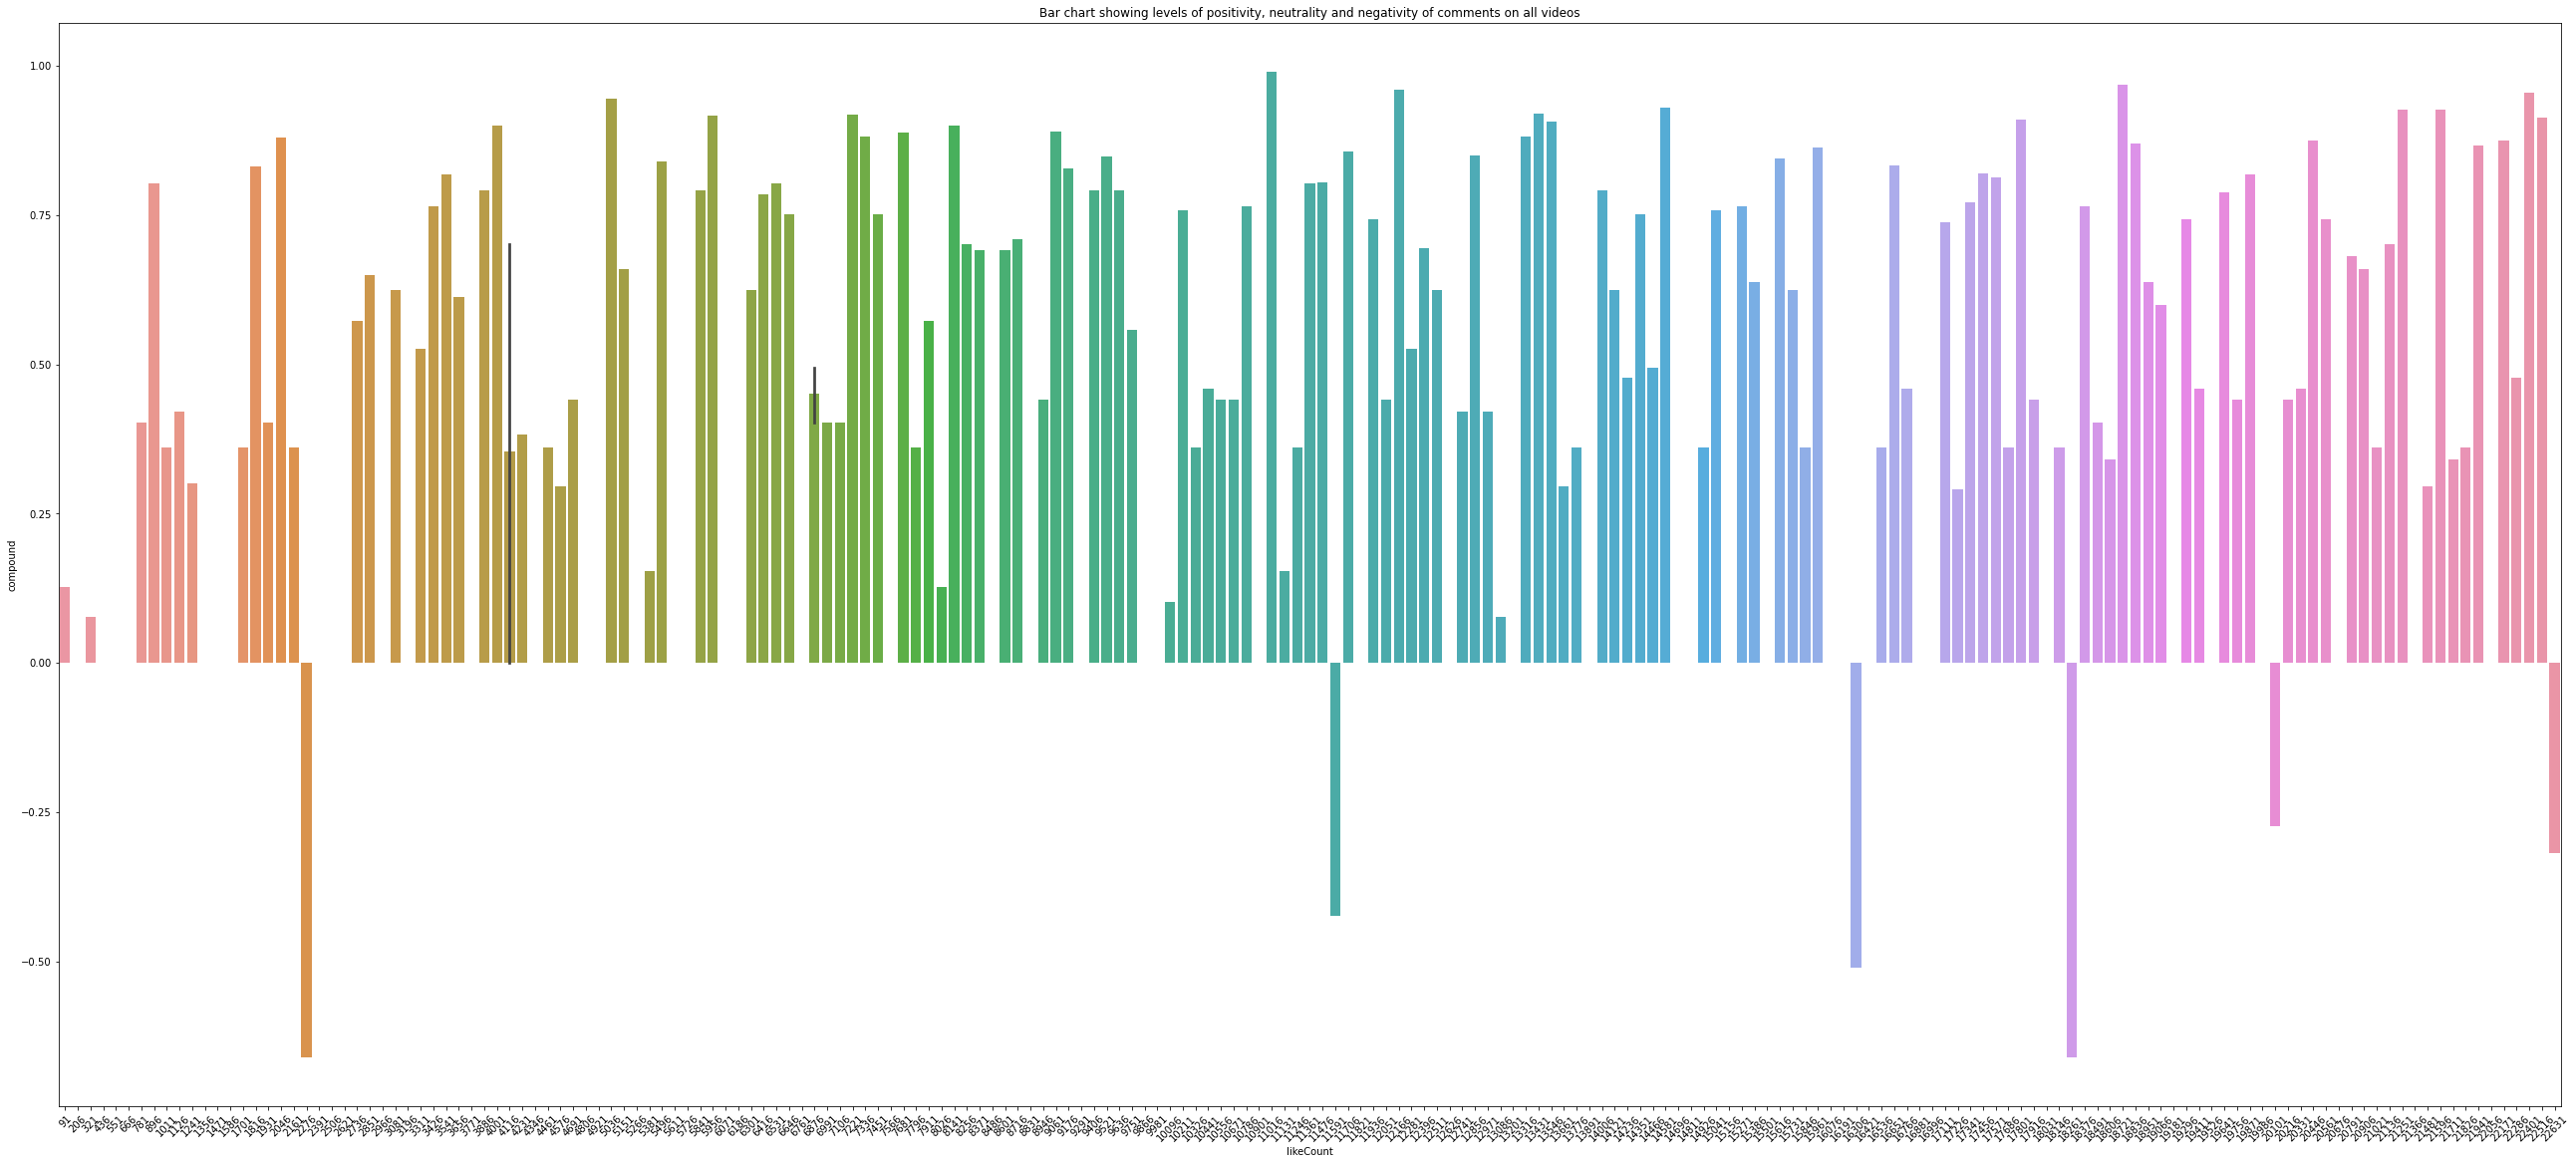

In [320]:
plt.figure(figsize = (45,20))
ax = sn.barplot(data = sorted_vader, x ='likeCount', y = 'compound' )
ax.set_xticklabels(labels= (range(91,22637, 115)),rotation = 45)
plt.title('Bar chart showing levels of positivity, neutrality and negativity of comments on all videos')
plt.show()

From the plot above, we can see that most videos generally have positive comments, except for a few which we will investigate later. 

In [316]:
pos_vade = len(vade.loc[vade['compound']>0])
neutral_vade = len(vade.loc[vade['compound']==0])
neg_vade = len(vade.loc[vade['compound']<0])
vals =[pos_vade, neutral_vade, neg_vade]
label =['positive', 'neutral', 'negative']
colours = ['green', 'grey', 'red']

<function matplotlib.pyplot.show(close=None, block=None)>

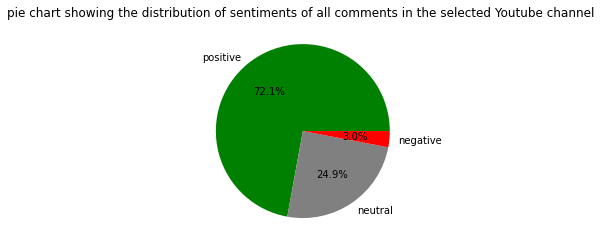

In [322]:
plt.pie(x = vals, labels=label, colors=colours, autopct = '%1.1f%%')
plt.title('pie chart showing the distribution of sentiments of all comments in the selected Youtube channel ')
plt.show

#### Now, I'll run a sentiment analysis on each comment for any video of my choice

In [174]:
comms = pd.DataFrame(all_comment)
ind_comms = comms.explode('comments') #This line enables us to have each comment as a row
ind_comms

,vid,comments
0,VRmXto2YA2I,is data analyst oversaturated? someone said th...
0,VRmXto2YA2I,"What did Boris do, to be the pandas course of ..."
0,VRmXto2YA2I,3:27 note that to avoid a FutureWarning (and a...
0,VRmXto2YA2I,“Squiggly bracket” > “curly bracket” 😂\n\nAlso...
0,VRmXto2YA2I,Thanks Sir
...,...,...
200,6lQzbk6_OTw,Knime?
200,6lQzbk6_OTw,"Hi Alex, Awesome content, should I learn machi..."
200,6lQzbk6_OTw,Alex thanks for being the voice young analysts...
200,6lQzbk6_OTw,Than alex


In [175]:
df_sample

,vid,comments,processed
5,dFA0E-6xT_M,Hi Alex! thank you for your videos. I just dis...,Hi Alex thank videos discovered channel unfort...
5,dFA0E-6xT_M,Thank you brother.,Thank brother
5,dFA0E-6xT_M,How come you haven't done any R projects,come R projects
5,dFA0E-6xT_M,$60/mo for Coursera if you need unlimited acce...,$ 60 mo Coursera need unlimited access diff co...
5,dFA0E-6xT_M,My motivation is passion for numbers; got a de...,motivation passion numbers got degree chem hel...
5,dFA0E-6xT_M,"Hi Alex,\r\nI am following you since last year...",Hi Alex \r\n following year benefited content
5,dFA0E-6xT_M,"Please, I downloaded SQL and installed but I g...",downloaded SQL installed got stuck told Input ...
5,dFA0E-6xT_M,"Hey alex, love you content....can you please m...",Hey alex love content video data analysis earn...
5,dFA0E-6xT_M,"Hi Alex, I am trying to do the SQL exploration...",Hi Alex trying SQL exploration portfolio proje...
5,dFA0E-6xT_M,"I missed the live stream, but watched everythi...",missed live stream watched \n\n actually start...


In [106]:
video_df['video_id'].unique()

array(['VRmXto2YA2I', '6yNsc7JVPJE', 'mBCG9J1TVTc', 'WizLaDdsHUs',
       'kB7FV-ijdqE', 'dFA0E-6xT_M', 'dUpyC40cF6Q', 'gs0FNQR0njI',
       'C75TROiiEa0', 'rGx1QNdYzvs', 'CUBfrdDwznQ', 'L-QnW_BZT3c',
       'S76iS03nGis', 'RBEgsEVO3T8', 'gCG07l6Fu-U', 'DXwFsxCtukg',
       'ey1VNjU0YbM', '0MKcCHrTo0c', 'bVJfQAe-UP4', '_2OknmkngkQ',
       'B63bN2cLVLM', 'zvzjaqMBEso', 'ECduJk00mUU', 'zmIdC0_0BgY',
       'eP8-mo5jRrY', '-BOBedcjySI', 'lPVke-p4S7s', 'ppsCxnNm-JI',
       'rVhHGPDzEck', 'pHOH7UfOhbE', 'sXHIIW3Wt84', 'WUeBzT43JyY',
       'DVs9u15htXU', 'zW3qJUeJLWc', 'm1AkWK_ODLM', 'Pfq-8pGzgg4',
       'pixlHHe_lNQ', '3NV5Jtbhfcw', '1cfrQLoJMPI', '9j_EBt3RNrs',
       'm0h3Ghl6mgY', '50D__p6jdEI', 'tRCGGlMI19M', '0QZBnhofU_U',
       'ulFY20KTzFQ', 'PEc29sRZoTM', 'DlEkWd-8VXA', 'vcijg0gUXSg',
       'gCg47n_TlFc', 'sW5LoDA1ssM', '4nsdARJGzJ0', '_QvQxm4dptI',
       'HX2TabgkzHo', 'gP-AxNi6uxo', 'KB2CtEDrglY', '2HfSFdPEFRg',
       'g0m5sEHPU-s', 'Q7i6zxHVj2Q', 'ddn-2r1j_OU', 'Pf-9pjJK1

In [334]:
def video_sentiment(ind_vid_id):
    sample_video_id = ind_vid_id
    df_sample = ind_comms[ind_comms['vid'] == sample_video_id]
    df_sample['processed'] = df_sample['comments'].apply(preprocess)

    df_sample['count_col'] = range(1, len(df_sample) + 1)



    i_res = {}
    for i, row in df_sample.iterrows():
        feedback = row['processed']
        vidId = row['count_col']
        i_res[vidId] = sia.polarity_scores(feedback)



    dicc = pd.DataFrame(i_res)
    dicc_df = dicc.T
    dicc_df['comment_id'] = dicc_df.index
    dicc_df
    plt.figure(figsize = (25,10))
    topic = video_df['title'].loc[video_df['video_id']== ind_vid_id]
    ax = sn.barplot(data = dicc_df, x ='comment_id', y = 'compound' )
    plt.title(f'Bar chart of comments VS sentiment for video with the title "{topic}" ')
    plt.show()
    
    pos_dicc_df = len(dicc_df.loc[dicc_df['compound']>0])
    neutral_dicc_df = len(dicc_df.loc[dicc_df['compound']==0])
    neg_dicc_df = len(dicc_df.loc[dicc_df['compound']<0])
    vals_ =[pos_dicc_df, neutral_dicc_df, neg_dicc_df]
    label =['positive', 'neutral', 'negative']
    colours = ['green', 'grey', 'red']
    
    plt.pie(x = vals_, labels=label, colors=colours, autopct = '%1.1f%%')
    plt.title('Pie chart showing the distribution of sentiments of all comments in a selected video')
    plt.show()
    
#ADD A COUNT AND USE THE COUNT COLUMN TO APPEND THE RESULT

In order to get a visualization of the sentiment of each comment on any video, simply copy and paste the video id on the video_sentiment function as seen below.

C:\Users\USER\AppData\Local\Temp\ipykernel_14736\3020616120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['processed'] = df_sample['comments'].apply(preprocess)
C:\Users\USER\AppData\Local\Temp\ipykernel_14736\3020616120.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['count_col'] = range(1, len(df_sample) + 1)


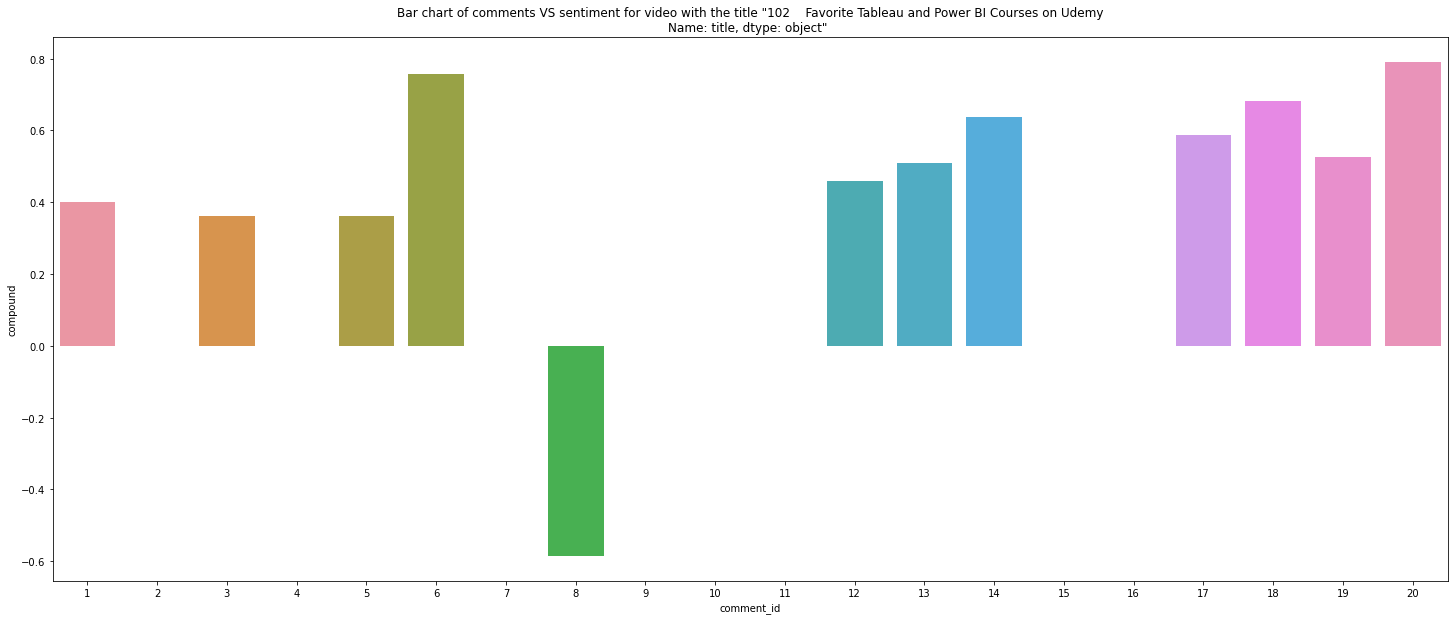

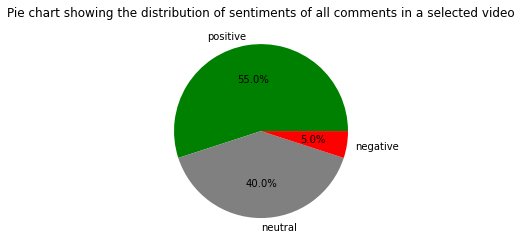

In [337]:
video_sentiment('RJw-GSXXguA')